In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

In [2]:
import constants
import config

In [3]:
base_path = "sweeps/"

In [4]:
# matplotlib.rcParams['figure.figsize'] = (16,8)
# matplotlib.rcParams["axes.xmargin"] = 0

In [5]:
# matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

In [6]:
def plot_bool_in_bg(x_axis, y_axis):
    ylims = plt.ylim()
    ylim_range = ylims[1] - ylims[0]
    no_val = ylims[0]+ylim_range*0.2
    yes_val = ylims[0]+ylim_range*0.8
    contacts_to_plot = np.ones_like(x_axis)*no_val
    contacts_to_plot[y_axis == 1] = yes_val
    plt.plot(x_axis, contacts_to_plot, linestyle=':', zorder=0)

# Single run sweeps

In [38]:
data = np.load(base_path + "traces.npz", allow_pickle=True)

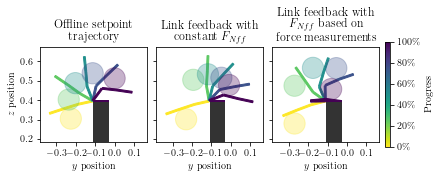

In [39]:
plot_manipulator = True

w_L = constants.nominal_sys_consts(config.NumLinks(4)).w_L
h_L = constants.nominal_sys_consts(config.NumLinks(4)).h_L
r = constants.nominal_sys_consts(config.NumLinks(4)).r

# Set to be arbitrary large/small numbers
# IMPORTANT: x and y here refer to PLOT x and ys, not sim
min_x = 10**9
min_y = 10**9
max_x = -10**9
max_y = -10**9

# Initialize plotting vars
fig, axs = plt.subplots(1, 3, figsize=(6,3), constrained_layout=True, sharex=True, sharey=True)
axs[0].set_ylabel("$z$ position")

# Iterate over data
titles = ["Offline setpoint\ntrajectory",
          r"Link feedback with" + "\n" +
          "constant $F_{Nff}$",
          "Link feedback with" + "\n" +
          "$F_{Nff}$ based on" + "\n" +
          "force measurements"]
cmap = plt.get_cmap("viridis_r")
for i, (data_, title) in enumerate(zip(data['out_data'], titles)):
    start_idx = data_["any_links_in_contact_idx"]
    start_time = data_["times"][start_idx]
    end_time = data_["times"][-1]
    time_range = end_time - start_time
    times_ = np.linspace(start_time, end_time, 5)
    ax = axs[i]

    # Draw rectangles over links
    for t in times_:
        c = cmap((t-start_time)/time_range)
        idx = np.argmax(data_["times"] >= t)

        for x, y, ang in zip(
                data_["horizontal_paper_traces"][:,idx],
                data_["vertical_paper_traces"][:,idx],
                data_["angle_paper_traces"][:,idx]):

            x0 = x - np.cos(ang)*w_L/2
            y0 = y - np.sin(ang)*w_L/2

            rect = plt. Rectangle((x0, y0), w_L, h_L,
                angle=ang*180/np.pi, color=c,)
            ax.add_patch(rect)

            # Compute bounds to be used
            min_x = min(x - w_L*1.1*0.5, min_x)
            min_y = min(y - w_L*1.1*0.5, min_y)
            max_x = max(x + w_L*1.1*0.5, max_x)
            max_y = max(y + w_L*1.1*0.5, max_y)

    # Add pedestal
    ## Get first pedestal location
    rect = plt.Rectangle(
        (data_["horizontal_paper_traces"][0,0]+w_L/2,
         data_["vertical_paper_traces"][0,0]),
        w_L,
        10,
        angle=180,
        color=(0.2, 0.2, 0.2, 1.0)
    )
    ax.add_patch(rect)

    # Add manipulator
    if plot_manipulator:
        for t in times_:
            c = cmap((t-start_time)/time_range)
            idx = np.argmax(data_["times"] >= t)

            x = data_["horizontal_manipulator_trace"][idx]
            y = data_["vertical_manipulator_trace"][idx]

            min_x = min(x - r*1.1, min_x)
            min_y = min(y - r*1.1, min_y)
            max_x = max(x + r*1.1, max_x)
            max_y = max(y + r*1.1, max_y)

            circ = plt.Circle((x, y), r*1.1, color=c, alpha=0.3, snap=False)
            ax.add_patch(circ)

    ax.set_xlabel("$y$ position")
    ax.set_aspect("equal")
    ax.title.set_text(title)
    
# Set lims (can do at the end because sharex and sharey are true)
min_plot_x = min_x - (max_x-min_x)*0.1
max_plot_x = max_x + (max_x-min_x)*0.1
min_x_tick = np.floor(min_plot_x*10)/10
max_x_tick = np.ceil(max_plot_x*10)/10
xticks = np.arange(min_x_tick, max_x_tick+1e-5, 0.1)
ax.set_xticks(xticks)

min_plot_y = min_y - (max_y-min_y)*0.1
max_plot_y = max_y + (max_y-min_y)*0.1
min_y_tick = np.floor(min_plot_y*10)/10
max_y_tick = np.ceil(max_plot_y*10)/10
yticks = np.arange(min_y_tick, max_y_tick+1e-5, 0.1)
ax.set_yticks(yticks)
ax.set_ylim(min_plot_y, max_plot_y)
plt.xlim(min_plot_x, max_plot_x)
cb = fig.colorbar(cm.ScalarMappable(cmap="viridis_r"), shrink=(0.5 if plot_manipulator else 0.6))
cb.set_label("Progress")
ticks = np.linspace(0, 100, 6)
cb.set_ticks(ticks/100)
cb.set_ticklabels([str(int(tick)) + "\%" for tick in ticks])

fig.savefig("traj_drawings.pgf", backend="pgf")
plt.show()

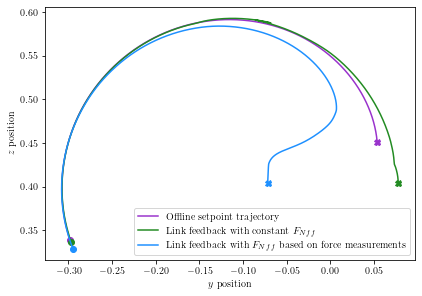

In [40]:
fig, axs = plt.subplots(1, 1, figsize=(6,4), constrained_layout=True)
colors = ["darkorchid", "forestgreen", "dodgerblue"]
titles = ["Offline setpoint trajectory",
          r"Link feedback with constant $F_{Nff}$",
          "Link feedback with $F_{Nff}$ based on force measurements"]
for i, (data_, color, title) in enumerate(zip(data['out_data'], colors, titles)):
    start_idx = data_["any_links_in_contact_idx"]
    plt.plot(data_["horizontal_paper_traces"][-1,start_idx:],
             data_["vertical_paper_traces"][-1,start_idx:], color=color, label=title)
    plt.plot(data_["horizontal_paper_traces"][-1,start_idx],
             data_["vertical_paper_traces"][-1,start_idx],
             marker='o', color=color)
    plt.plot(data_["horizontal_paper_traces"][-1,-1],
             data_["vertical_paper_traces"][-1,-1], marker='X', color=color)
plt.legend()
plt.xlabel("$y$ position")
plt.ylabel("$z$ position")
plt.gca().set_aspect("equal")


fig.savefig("traj_plots.pgf", backend="pgf")
plt.show()

# Sweeps

## ff_FN

In [ ]:
data1 = np.load(base_path + "constant_Fn__ff_FN.npz")
data2 = np.load(base_path + "measured_Fn__ff_FN.npz")

plt.plot(data1["x_axis"], data1["y_axis"]["max_overall_theta"], '--o')
plot_bool_in_bg(data1["x_axis"], data1["successes"])

plt.plot(data2["x_axis"], data2["y_axis"], '--o')
plot_bool_in_bg(data2["x_axis"], data2["successes"])
# plt.show()

## Link mass

In [ ]:
data1 = np.load(base_path + "constant_Fn__m_L.npz")
data2 = np.load(base_path + "measured_Fn__m_L.npz")
data3 = np.load(base_path + "offline__m_L.npz")

plt.plot(data1["x_axis"], data1["y_axis"], '--o')
plot_bool_in_bg(data1["x_axis"], data1["successes"])

plt.plot(data2["x_axis"], data2["y_axis"], '--o')
plot_bool_in_bg(data2["x_axis"], data2["successes"])

plt.plot(data3["x_axis"], data3["y_axis"], '--o')
plot_bool_in_bg(data3["x_axis"], data3["successes"])
# plt.show()

## Stiffness

In [ ]:
data1 = np.load(base_path + "constant_Fn__k_J.npz")
data2 = np.load(base_path + "measured_Fn__k_J.npz", allow_pickle=True)
data3 = np.load(base_path + "offline__k_J.npz", allow_pickle=True)

plt.plot(data1["x_axis"][:,0], data1["y_axis"], '--o', label="Constant")
plot_bool_in_bg(data1["x_axis"][:,0], data1["successes"])

plt.plot(data2["x_axis"][:,0], data2["y_axis"], '--o', label="Measured")
plot_bool_in_bg(data2["x_axis"][:,0], data2["successes"])

plt.plot(data3["x_axis"][:,0], data3["y_axis"], '--o', label="Offline")
plot_bool_in_bg(data3["x_axis"][:,0], data3["successes"])

plt.legend()
plt.show()

# Coefficient of friction

In [ ]:
data1 = np.load(base_path + "constant_Fn__mu.npz")
data2 = np.load(base_path + "measured_Fn__mu.npz", allow_pickle=True)
data3 = np.load(base_path + "offline__mu.npz", allow_pickle=True)

plt.plot(data1["x_axis"][:,0], data1["y_axis"], '--o', label="Constant")
plot_bool_in_bg(data1["x_axis"][:,0], data1["successes"])

plt.plot(data2["x_axis"][:,0], data2["y_axis"], '--o', label="Measured")
plot_bool_in_bg(data2["x_axis"][:,0], data2["successes"])

plt.plot(data3["x_axis"][:,0], data3["y_axis"], '--o', label="Offline")
plot_bool_in_bg(data3["x_axis"][:,0], data3["successes"])

plt.legend()
plt.show()

# Damping

In [ ]:
# data1 = np.load(base_path + "constant_Fn__b_J.npz")
data2 = np.load(base_path + "measured_Fn__b_J.npz", allow_pickle=True)
data3 = np.load(base_path + "offline__b_J.npz", allow_pickle=True)

# plt.plot(data1["x_axis"][:,0], data1["y_axis"], '--o', label="Constant")
# plot_bool_in_bg(data1["x_axis"][:,0], data1["successes"])

plt.plot(data2["x_axis"][:,0], data2["y_axis"], '--o', label="Measured")
plot_bool_in_bg(data2["x_axis"][:,0], data2["successes"])

# plt.plot(data3["x_axis"][:,0], data3["y_axis"], '--o', label="Offline")
# plot_bool_in_bg(data3["x_axis"][:,0], data3["successes"])

plt.legend()
plt.show()

# Noise

In [34]:
data = np.load(base_path + "measured_Fn__Fn_noise.npz", allow_pickle=True)

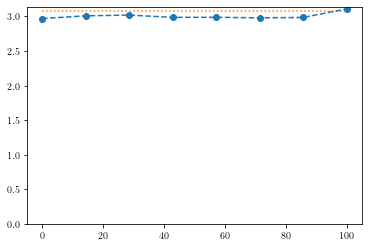

In [35]:
x_axis = data["sweep_vars"][:,0]
y_axis = [val["max_overall_theta"] for val in data["out_data"]]
plt.plot(x_axis, y_axis, '--o')
plot_bool_in_bg(data["sweep_vars"][:,0], data["successes"])

plt.ylim(0, np.pi)
plt.show()

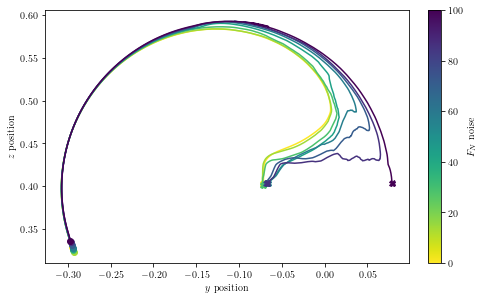

In [36]:
fig, axs = plt.subplots(1, 1, figsize=(6,4), constrained_layout=True)
max_val = np.max(data['sweep_vars'])

cmap = plt.get_cmap("viridis_r")
for i, (data_, Fn_noise) in enumerate(zip(data['out_data'], data['sweep_vars'].flatten())):
    c = cmap(Fn_noise/max_val)
    start_idx = data_["any_links_in_contact_idx"]
    p = plt.plot(data_["horizontal_paper_traces"][-1,start_idx:],
             data_["vertical_paper_traces"][-1,start_idx:], color=c)
    plt.plot(data_["horizontal_paper_traces"][-1,start_idx],
             data_["vertical_paper_traces"][-1,start_idx],
             marker='o', color=c)
    plt.plot(data_["horizontal_paper_traces"][-1,-1],
             data_["vertical_paper_traces"][-1,-1], marker='X', color=c)
plt.xlabel("$y$ position")
plt.ylabel("$z$ position")


fig.savefig("traj_plots.pgf", backend="pgf")
cb = fig.colorbar(cm.ScalarMappable(cmap="viridis_r", norm=plt.Normalize(0,100)))
plt.gca().set_aspect("equal")
cb.set_label("$F_N$ noise")
plt.show()

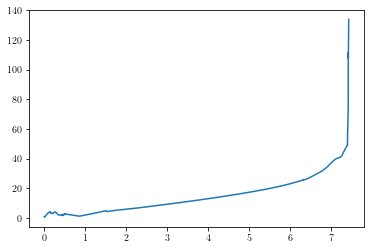

In [37]:
plt.figure()
plt.plot(data["out_data"][0]["times"], data["out_data"][0]["max_F_ONs"])

In [32]:
idx_start

1